# 观测站数据介绍

观测站数据是气象和环境监测的重要基础数据，记录了各类气象要素（如温度、湿度、能见度、风速、降水等）在固定地点和时间的观测值。数据通常来源于地面气象站、监测塔或其他观测设备。  
下载地址：https://data.cma.cn
## 数据存储格式

观测站数据可以以多种格式保存，常见的包括：

1. **CSV（Comma-Separated Values）格式**
   - 每行代表一个观测记录，每列代表一个气象变量或元数据。
   - 示例：
     ```csv
     StationID,Lon,Lat,VIS,VIS_HOR_1MI,VIS_HOR_10MI
     101,116.3,39.9,800,700,750
     102,117.2,40.1,1200,1100,1150
     ```

2. **JSON（JavaScript Object Notation）格式**
   - 使用键值对描述观测站信息，便于存储嵌套结构或元数据。
   - 示例：
     ```json
     {
       "DS": [
         {"StationID":101, "Lon":116.3, "Lat":39.9, "VIS":800, "VIS_HOR_1MI":700, "VIS_HOR_10MI":750},
         {"StationID":102, "Lon":117.2, "Lat":40.1, "VIS":1200, "VIS_HOR_1MI":1100, "VIS_HOR_10MI":1150}
       ]
     }
     ```

3. **TXT（文本）格式**
   - 一般为纯文本，列之间可用空格或制表符分隔。
   - 示例：
     ```
     StationID Lon Lat VIS VIS_HOR_1MI VIS_HOR_10MI
     101 116.3 39.9 800 700 750
     102 117.2 40.1 1200 1100 1150
     ```
   - 或数据以json格式保存在txt文件中

In [1]:
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt

obs_path = '/data/xmr/xmrcode/data_process/data/obs/20231224000000_20231224000100.txt'

with open(obs_path, 'r', encoding='utf-8') as f:
    outer_json = json.load(f)
    
# 解析里面 data 字段的字符串为 json 对象
inner_json = json.loads(outer_json['data'])

# 提取里面的 "DS" 字段（是一个列表，每条是一个观测记录）
data = pd.DataFrame(inner_json['DS'])
print(data.head(10)) 

  Station_Id_C Station_levl      Lat       Lon   Alti             Datetime  \
0        58563           12  29.8811  121.8256      5  2023-12-24 00:00:00   
1        54755           12  37.3283  120.3869  117.8  2023-12-24 00:00:00   
2        54318           12  41.3442  117.7292    600  2023-12-24 00:00:00   
3        54338           12  41.2742  122.0403    4.8  2023-12-24 00:00:00   
4        54345           12  41.2003  123.0736   30.7  2023-12-24 00:00:00   
5        54728           12  37.7619  117.3525   10.5  2023-12-24 00:00:00   
6        58241           12  32.7569  119.4864    6.5  2023-12-24 00:00:00   
7        54913           12  35.7953  116.8067   67.6  2023-12-24 00:00:00   
8        54483           12  40.8719  123.9017  233.6  2023-12-24 00:00:00   
9        54423           12  40.9742  117.9211  422.2  2023-12-24 00:00:00   

   Year Mon Day Hour  ...    DPT RHU     PRE    VIS VIS_HOR_1MI VIS_HOR_10MI  \
0  2023  12  24    0  ...   -6.5  58  999999  10800       122

In [2]:
# ==== Step 1. 读取经纬度与能见度 ====
longitude = data['Lon'].astype(float).tolist()
latitude = data['Lat'].astype(float).tolist()
vis = data['VIS'].astype(float).tolist()
vis_1mi = data['VIS_HOR_1MI'].astype(float).tolist()
vis_10mi = data['VIS_HOR_10MI'].astype(float).tolist()

In [3]:
# ==== Step 2. 定义加权能见度计算函数 ====
def calculate_weighted_visibility(vis, vis_1mi, vis_10mi):
    vis = np.array(vis)
    vis_1mi = np.array(vis_1mi)
    vis_10mi = np.array(vis_10mi)
    # 这里只是示例，实际权重规则请根据业务替换
    return (vis + vis_1mi + vis_10mi) / 3

vis_avg = calculate_weighted_visibility(vis, vis_1mi, vis_10mi)

# 将能见度转换为分类值
vis_class = np.full_like(vis_avg, -1)
vis_class[(vis_avg > 0) & (vis_avg < 200)] = 5
vis_class[(vis_avg >= 200) & (vis_avg < 500)] = 4
vis_class[(vis_avg >= 500) & (vis_avg < 1000)] = 3
vis_class[(vis_avg >= 1000) & (vis_avg < 2000)] = 2
vis_class[(vis_avg >= 2000)] = 1

In [4]:
# ==== Step 3. 定义区域与格点 ====
# region = [lat_min, lat_max, lon_min, lon_max, dpi]
region = [28.7, 41.5, 116.2, 129.0, 0.0125]  # 举例：纬度20-30，经度110-120，分辨率0.1°
dpi = region[-1]

pic_lat_min, pic_lat_max = region[0], region[1]
pic_lon_min, pic_lon_max = region[2], region[3]

pic_lon_inter = int((pic_lon_max - pic_lon_min) / dpi)
pic_lat_inter = int((pic_lat_max - pic_lat_min) / dpi)

pic_lon = np.linspace(pic_lon_min, pic_lon_max, pic_lon_inter)
pic_lat = np.linspace(pic_lat_min, pic_lat_max, pic_lat_inter)

lon_grid, lat_grid = np.meshgrid(pic_lon, pic_lat)

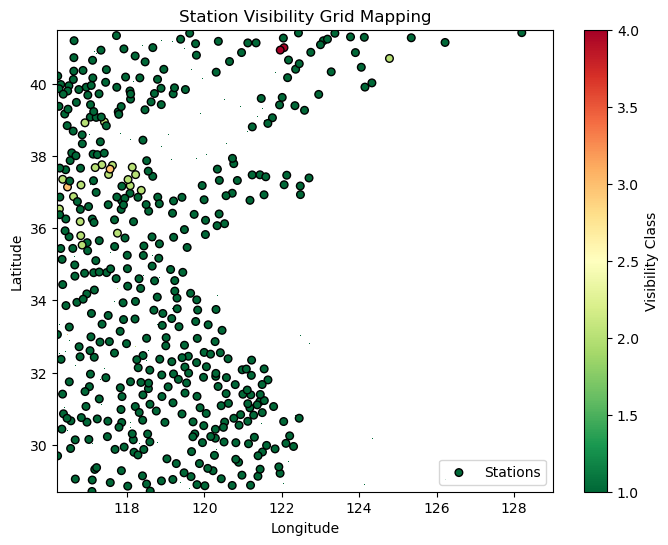

In [5]:
# ==== Step 4. 将观测站数据映射到格点 ====
# 简单最近邻插值
vis_grid = np.full_like(lon_grid, np.nan, dtype=float)
# 注意经纬度方向
for lon, lat, val in zip(longitude, latitude, vis_class):
    # 竖直方向翻转
    i = int((pic_lat_max - lat) / dpi)  
    j = int((lon - pic_lon_min) / dpi)
    
    if 0 <= i < vis_grid.shape[0] and 0 <= j < vis_grid.shape[1]:
        vis_grid[i, j] = val
        
# ==== Step 5. 可视化 ====
plt.figure(figsize=(8, 6))
plt.pcolormesh(lon_grid, lat_grid, vis_grid, cmap='RdYlGn_r', shading='auto')
plt.colorbar(label="Visibility Class")

# 绘制观测站点
plt.scatter(longitude, latitude, c=vis_class, cmap='RdYlGn_r', edgecolor='k', s=30, label="Stations")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Station Visibility Grid Mapping")
plt.legend()
plt.show()

In [6]:
# 保存结果npy
import os

# ==== Step 6. 保存结果到 .npy 文件 ====
save_path = "/data/xmr/xmrcode/data_process/data/output/obs/vis_grid.npy"   # 这里换成你自己的目标路径
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # 确保目录存在

np.save(save_path, vis_grid)

print(f"保存成功: {save_path}")

保存成功: /data/xmr/xmrcode/data_process/data/output/obs/vis_grid.npy


In [7]:
from PIL import Image
import cv2
# ==== Step 1: 处理数值范围 ====
# PNG 只支持整数 0-255，这里做线性归一化
vis_grid[vis_grid>0] = 255

vis_grid = vis_grid.astype(np.uint8)                  # 转 uint8

kernel = np.ones((3,3), np.uint8)  # 3x3 的膨胀核
vis_grid = cv2.dilate(vis_grid, kernel, iterations=1)  # iterations 可调节膨胀强度



png_path = "/data/xmr/xmrcode/data_process/data/output/obs/vis_grid.png"
# ==== Step 2: 保存为 PNG ====
os.makedirs(os.path.dirname(png_path), exist_ok=True)
img = Image.fromarray(vis_grid)
img.save(png_path)

print(f"PNG 保存成功: {png_path}")

PNG 保存成功: /data/xmr/xmrcode/data_process/data/output/obs/vis_grid.png
